In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, ScalarFormatter

from plato.instrument.detection import DetectionModel, NoiseModel
from plato.stars import filter_valid_targets, filter_p1_targets
from plato.utils import create_grid
from plato.visualisation import (
    FigureProcessor,
    get_palette,
    set_plot_defaults,
    contour_plot,
)

In [126]:
set_plot_defaults()

figure_directory = f"../figures/05_detection_efficiency/"
save = True

In [127]:
LOPS2 = pd.read_csv(f"../data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(f"../data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[["Radius", "Mass", "u1", "u2", "gaiaV", "n_cameras", "Population"]]

fields["cos_i"] = 0
fields["sigma_star"] = 1e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

p1_sample = filter_p1_targets(fields)

## PLOT EXAMPLE DETECTION EFFICIENCY

In [128]:
# create planet property grid
n_example = 1000
porb, r_planet, planet_grid = create_grid(
    n_example,
    (1, 730),
    (0.3, 1.2),
    space="geom",
    return_as="dataframe",
    columns=["P_orb", "R_planet"],
)

planet_grid = planet_grid.assign(  # type: ignore
    R_star=1,
    M_star=1,
    Magnitude_V=11,
    n_cameras=24,
    cos_i=0,
    sigma_star=1e-6,
    u1=0.4,
    u2=0.15,
)

In [129]:
detection_efficiency = (
    DetectionModel().detection_efficiency(planet_grid).reshape(n_example, n_example)  # type: ignore
)

In [130]:
earth_marker = {
    "x": 365,
    "y": 1,
    "s": 200,
    "linewidth": 2.5,
    "alpha": 0.8,
    "facecolors": "none",
    "edgecolors": "white",
    "zorder": 1000,
}

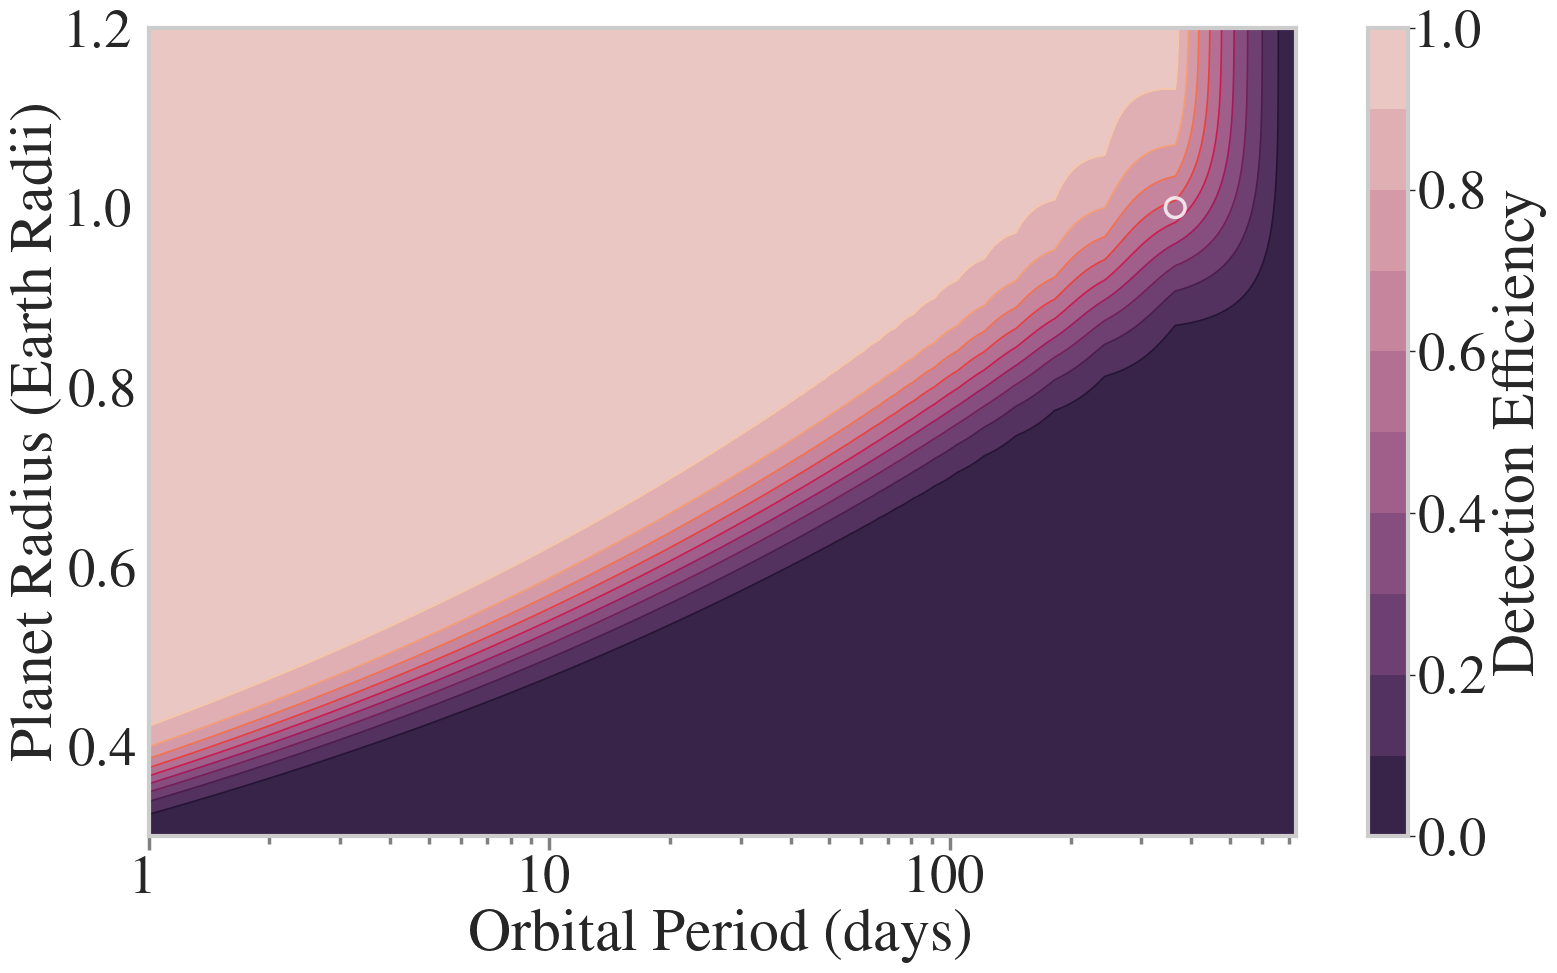

In [131]:
fig, ax, cbar = contour_plot(
    porb,
    r_planet,
    detection_efficiency,
    contourf_kwargs={
        "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "cmap": get_palette(n_colors=10, as_cmap=True, reverse=True),
    },
    contour_kwargs={
        "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    },
)

# adjust ticks
ax.set_xscale("log")
ax.tick_params(
    axis="x",
    which="both",
    direction="out",
    bottom=True,
    left=True,
    color="grey",
    width=2.5,
)
ax.tick_params(axis="x", which="major", length=10)
ax.tick_params(axis="x", which="minor", length=6)
ax.xaxis.set_major_locator(LogLocator())
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_xlabel("Orbital Period (days)")
ax.set_ylabel("Planet Radius (Earth Radii)")

# add marker for earth
ax.scatter(**earth_marker)

cbar.set_label("Detection Efficiency")


FigureProcessor(fig).save(
    "detection_efficiency_example_contour.pdf",
    figure_directory=figure_directory,
    save=save,
)

## PLOT DETECTION EFFICIENCY FOR FIELD TARGETS

In [75]:
# create planet property grid
n_example = 50
porb, r_planet, planet_grid = create_grid(
    n_example,
    (1, 730),
    (0.1, 10),
    space="geom",
    return_as="dataframe",
    columns=["P_orb", "R_planet"],
)

In [76]:
def compute_detectable_fraction(
    planet_properties,
    targets,
    detection_model,
    threshold,
):
    # compute detection efficiency and fraction of 'detectable' planets
    targets = targets.assign(
        R_planet=planet_properties["R_planet"],
        P_orb=planet_properties["P_orb"],
    )
    de = detection_model.detection_efficiency(targets)
    return sum(de > threshold) / len(de)


def compute_detectable_fractions(
    planet_properties,
    targets,
):
    results = []
    for _, row in planet_properties.iterrows():
        frac = compute_detectable_fraction(
            row,
            targets,
            DetectionModel(),
            threshold=1 / len(targets),
        )
        results.append(frac)
    return np.array(results)

In [ ]:
detection_effs_samples = []

# compute detection efficiency for P1 and all targets
# 'detectable' if detection efficiency > 1/N
for sample in [p1_sample, fields]:
    results = compute_detectable_fractions(planet_grid, sample)
    detection_effs_samples.append(np.array(results).reshape(n_example, n_example))

In [ ]:
for name, sample in zip(["p1", "all"], detection_effs_samples):
    fig, ax, cbar = contour_plot(
        porb,
        r_planet,
        sample,
        contourf_kwargs={
            "levels": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            "cmap": get_palette(n_colors=10, as_cmap=True, reverse=True),
        },
        contour_kwargs={
            "levels": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        },
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    # adjust ticks
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        bottom=True,
        left=True,
        width=2.5,
        color="grey",
    )
    ax.tick_params(axis="both", which="major", length=10)
    ax.tick_params(axis="both", which="minor", length=6)
    ax.xaxis.set_major_locator(LogLocator())
    ax.xaxis.set_major_formatter(ScalarFormatter())

    ax.set_xlabel("Orbital Period (days)")
    ax.set_ylabel("Planet Radius (Earth Radii)")

    # add marker for earth
    ax.scatter(**earth_marker)

    cbar.set_label("Fraction of Detectable Planets")

    FigureProcessor(fig).save(
        f"detection_efficiency_fraction_{name}.pdf",
        figure_directory=figure_directory,
        save=save,
    )

## PLOT DETECTION EFFICIENCY AS FUNCTION OF RADIUS

In [78]:
detection_effs_pops = []

# compute detection efficiency for P1 and all targets
# 'detectable' if detection efficiency > 1/N
for pop in ["Halo", "Thick Disk", "Thin Disk"]:
    sample = fields[fields["Population"] == pop]
    results = compute_detectable_fractions(planet_grid, sample)
    detection_effs_pops.append(np.array(results).reshape(n_example, n_example))

In [81]:
o = [o.sum(axis=1) for o in detection_effs_pops]

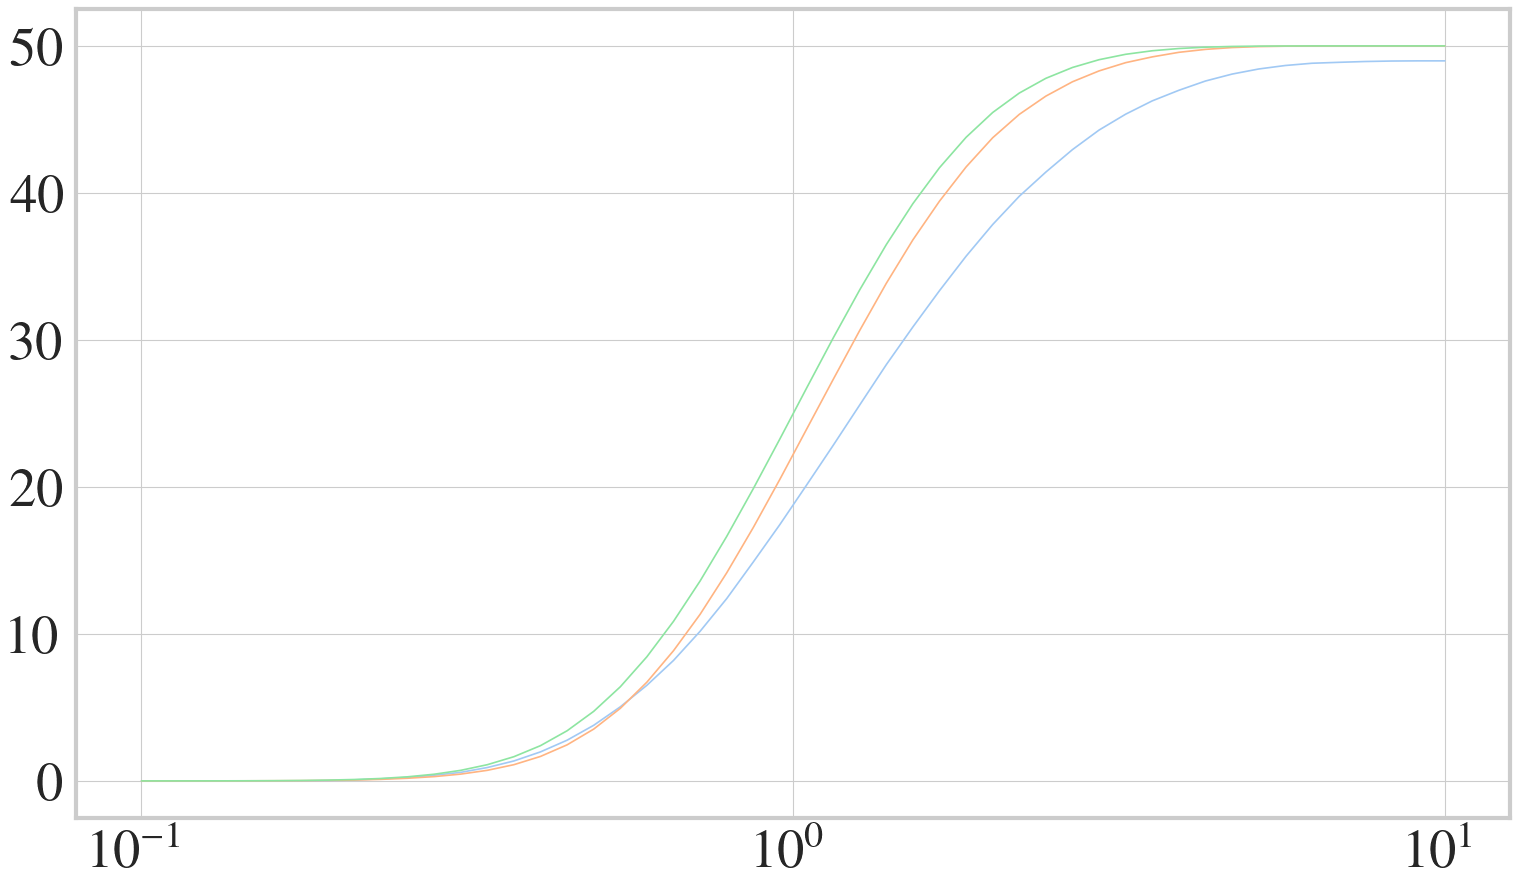

In [85]:
plt.semilogx(r_planet, o[0], label="Halo")
plt.semilogx(r_planet, o[1], label="Thick Disk")
plt.semilogx(r_planet, o[2], label="Thin Disk")